In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from einops import rearrange
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.utils.data import DataLoader, Dataset

In [23]:
!pip3 install einops


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install tqdm

In [ ]:
# !python3 dataloader.py

In [ ]:
!pip3 install opencv-python

In [ ]:
# from dataloader import create_gw_loaders

# Define loader (will be in an external file)

In [ ]:
from random import triangular
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import numpy.random as npr
import os

import pandas as pd
import cv2

import matplotlib.pyplot as plt

from torchvision import transforms
from PIL import Image, ImageChops, ImageDraw, ImageOps
from torchvision.io import read_image

pic_sz = 80

'''
    one font is one batch. After that it can be sliced into subsets.
'''

def ping():
    return "pong"

def get_ord(name):
    return name.slice("_")[-2]

def convert(r_image):
    numpy_image = cv2.cvtColor(r_image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(numpy_image, (pic_sz, pic_sz)).astype(np.float32)
    image = image.reshape(-1)
    return image

def getImage(font:str, char: str):
    return Image.open(f"gwfonts/converted/train/{font}/{font}_{ord(char)}.png")


def resize(image):
    image_size = image.size
    width = image_size[0]
    height = image_size[1]

    if width != height:
        bigside = width if width > height else height

        background = Image.new('RGBA', (bigside, bigside), (255, 255, 255, 255))
        offset = (int(round(((bigside - width ) / 2), 0)), int(round(((bigside - height) / 2), 0)))

        background.paste(image, offset)
        return background
    return image


def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0, 0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return resize(im.crop(bbox)).convert('L').resize((pic_sz, pic_sz))


class GwFontsDataset(Dataset):
    def __init__(
            self,
            train: bool,
            dataset_len: int,
            converted_dir,
            batch_size=1,
            alphabet=[chr(ord('A') + i) for i in range(26)] + [chr(ord('a') + i) for i in range(26)] + [str(i) for i in range(10)]
    ):
        self.directory = converted_dir + ("train" if train else "test")
        self.font_names = [dirname for dirname in os.listdir(self.directory) if dirname != '.DS_Store']
        self.font_len = len(self.font_names)
        self.dataset_len = dataset_len
        self.train = train
        self.test = not self.train
        self.alphabet = alphabet
        self.batch_size = batch_size


        self.alphabet_len = 2 * 26 + 10
        if self.test:
            self.train_directory = converted_dir + "train"
            self.train_names = [dirname for dirname in os.listdir(self.train_directory)][:self.nsamples]

    def __len__(self):
        return self.dataset_len


    @staticmethod
    def num_to_ord(idx):
        if idx < 10:
            return ord('0') + idx
        if idx < 36:
            return ord('A') + idx - 10
        return ord('a') + idx - 36


    def __getitem__(self, idx):
        transform = transforms.Compose([
            # transforms.Normalize()
            # transforms.ToTensor(),
            # lambda x: x.type(torch.float)
            # transforms.Resize((pic_sz, pic_sz)),
        ])
        dirname = self.font_names[idx]
        letter = np.random.choice(self.alphabet, 1)[0]
        # print(letter)
        pics = (read_image(f"{self.directory}/{dirname}/{dirname}_{ord(letter)}.png"), letter)
        # print('size', len(pics[0]))
        # subset, alph = self.get_ordered_images(idx)
        # subset_letters, subset_pics = subset
        # print('__getitem__')
        # result = [(pics[i], letters[i]) for i in range(len(letters))]
        return pics # torch.stack(list(map(lambda x: transform(x), pics))), letters


def create_gw_data(converted_dir, batch_size):
    return GwFontsDataset(train=True, dataset_len=800, converted_dir=converted_dir, batch_size=batch_size), GwFontsDataset(train=True, dataset_len=800, converted_dir=converted_dir, batch_size=batch_size),


def create_gw_loaders(converted_dir="gwfonts/converted/", batch_size=1, nsamples=10):
    data = create_gw_data(converted_dir, batch_size)

    return DataLoader(data[0], batch_size=batch_size, shuffle=True), \
        DataLoader(data[1], batch_size=batch_size, shuffle=False)


In [110]:
BATCH_SIZE = 4
train_loader, test_loader = create_gw_loaders("gwfonts/converted/", batch_size=BATCH_SIZE)
def show_batch(n_batches = 2):
    fig, axs = plt.subplots(n_batches, BATCH_SIZE, figsize=(20, 20), sharey=True, squeeze=False)
    for ind, batch in enumerate(train_loader):
        if ind == n_batches:
            break
        print(batch[1])
        batch = rearrange(batch[0], 'bs c w h -> bs w h c')
        print(batch[0].shape)
        for i in range(BATCH_SIZE):
            axs[ind, i].imshow(batch[i])
    fig.tight_layout()

('0', 'u', 'k', 'a')
torch.Size([80, 80, 1])
('a', 'k', 'I', 'R')
torch.Size([80, 80, 1])
('k', 'K', 'A', 'p')
torch.Size([80, 80, 1])
('d', 'D', 'C', 'b')
torch.Size([80, 80, 1])
('W', 'X', 'i', 'm')
torch.Size([80, 80, 1])
('G', 'z', 'R', '6')
torch.Size([80, 80, 1])


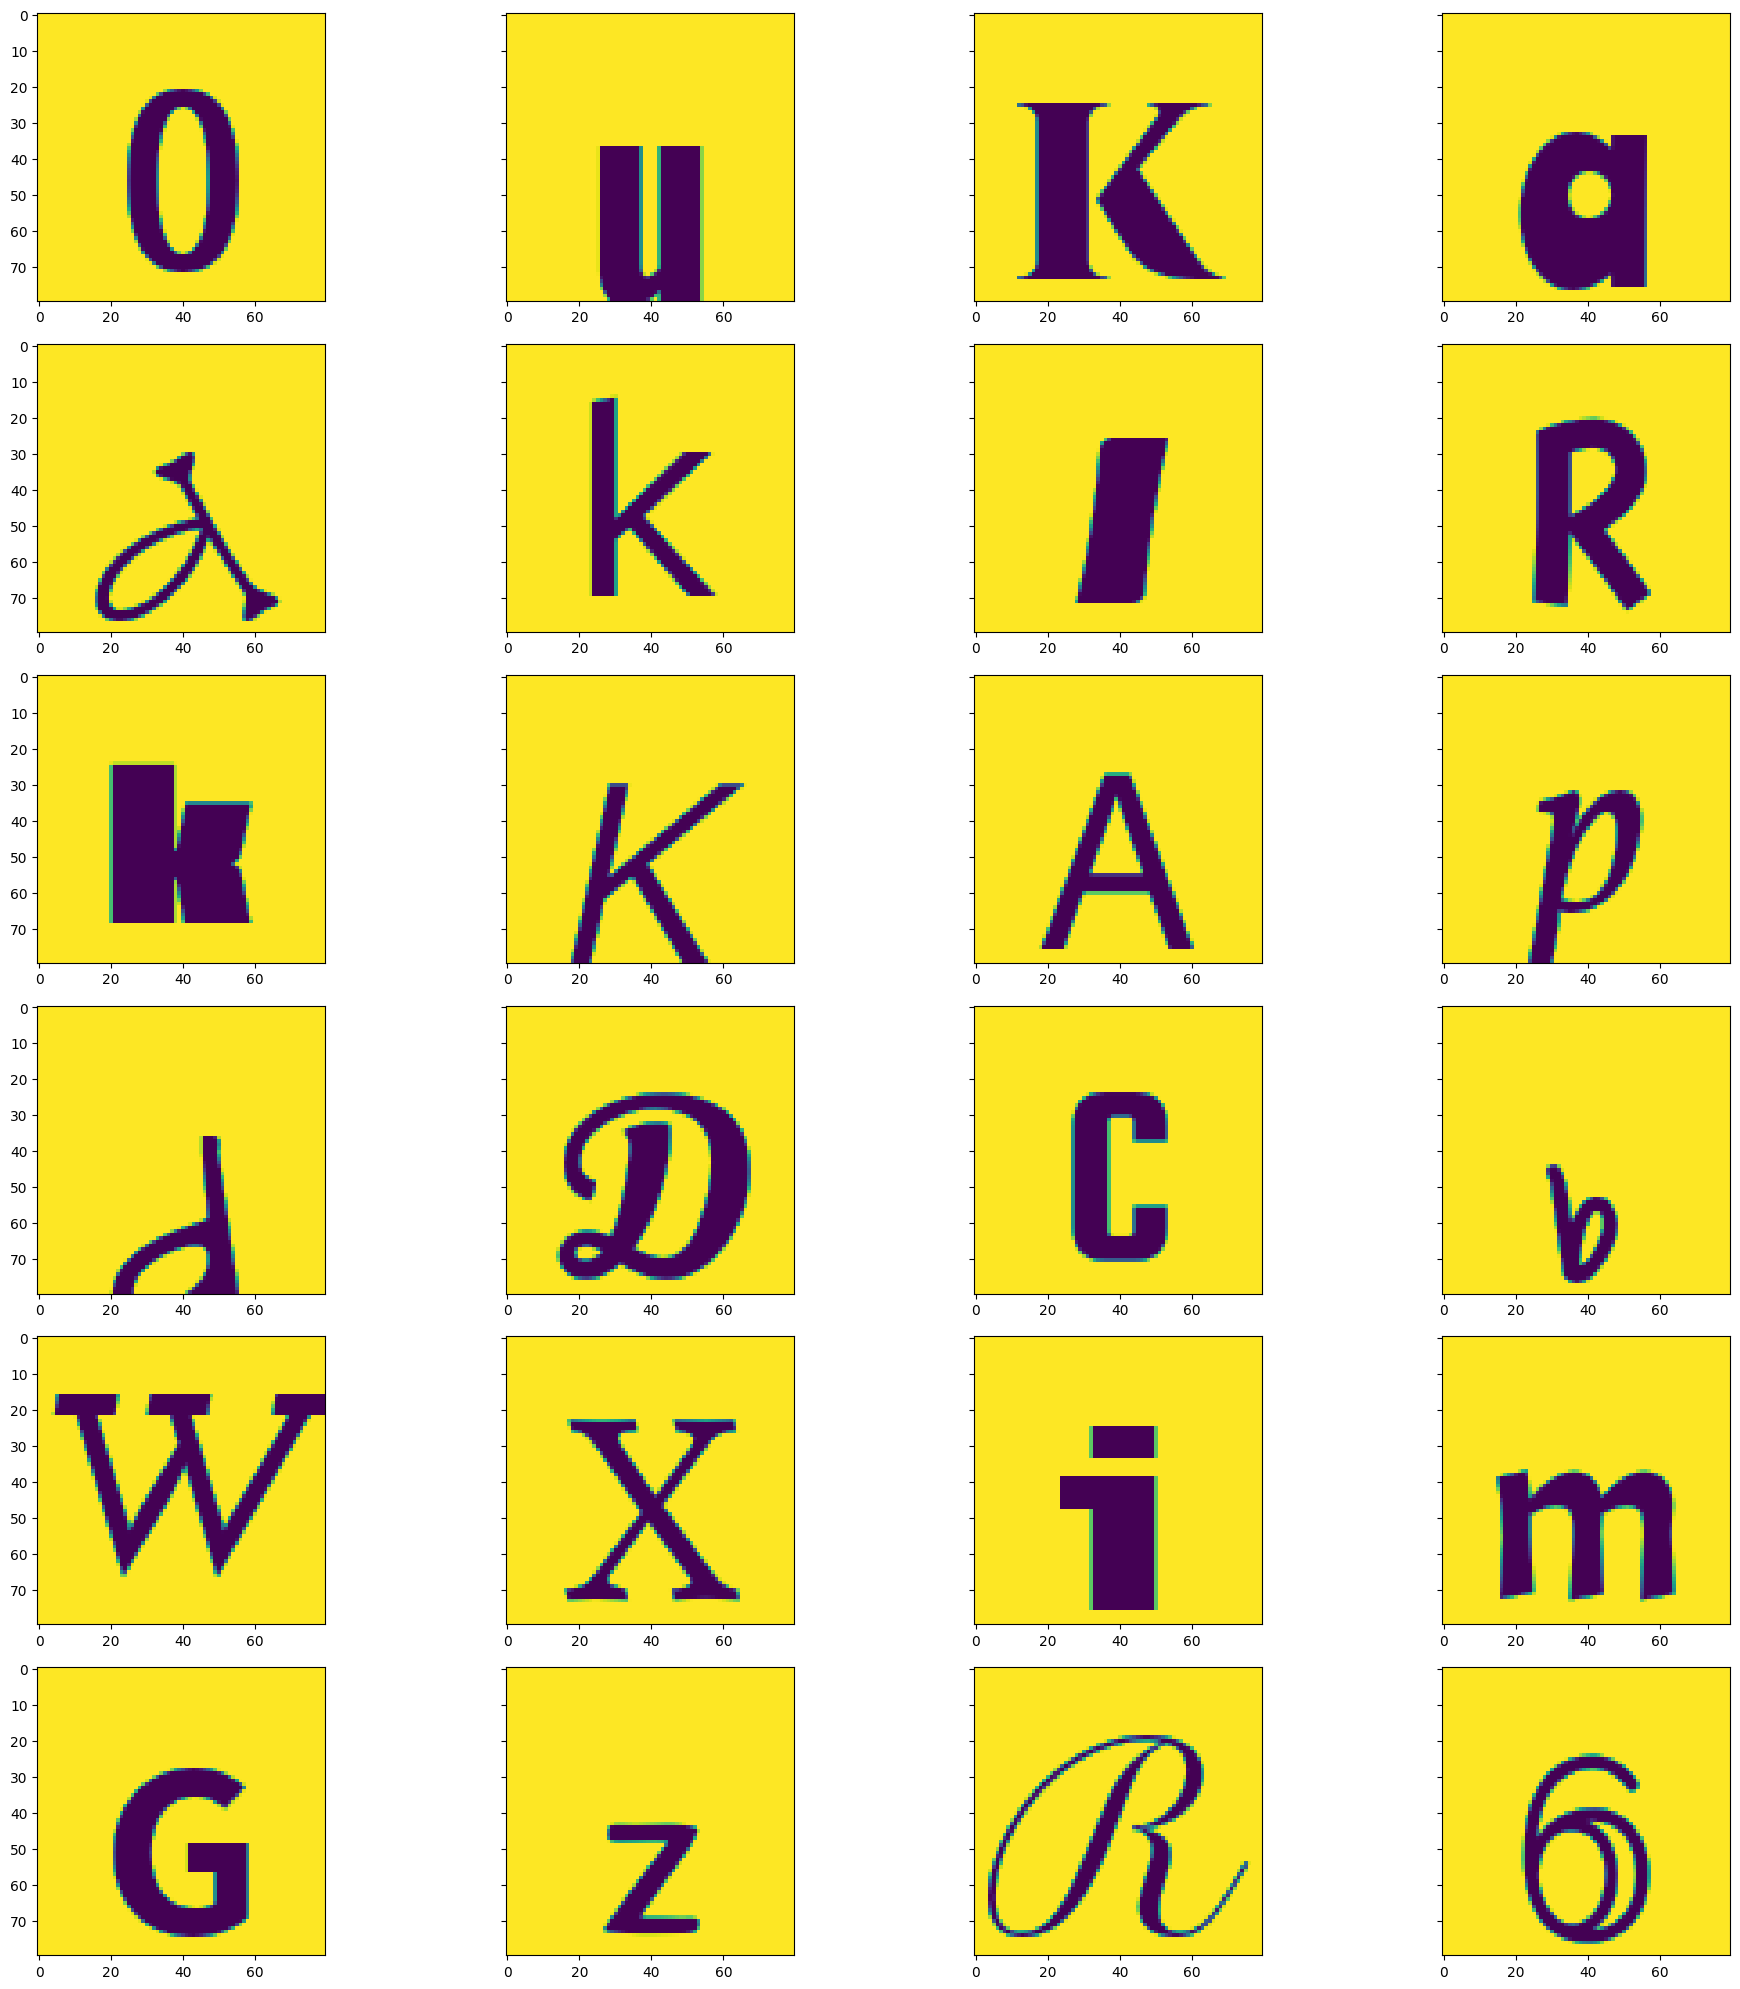

In [111]:
show_batch(6)

# END of imports. Code starts

In [93]:
labels = [chr(ord('A') + i) for i in range(26)] + [chr(ord('a') + i) for i in range(26)] + [str(i) for i in range(10)]
print(labels)
def one_hot_encode(x):
    return torch.FloatTensor([int(i == x) for i in labels])
print(one_hot_encode('5'))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0.])


In [102]:
working_directory = "drive/MyDrive/Files/gwfonts/converted/"

latent_dims = 10
alphabet_size = len(labels)
num_epochs = 100
batch_size = 10
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True
intermediate = 500 # as in the article


In [104]:
Encoder = nn.Sequential(
            nn.Linear(in_features = 1*80*80, out_features = intermediate),
            nn.Tanh(),
            nn.Linear(in_features= intermediate, out_features=intermediate),
            nn.Tanh(),
            nn.Linear(in_features= intermediate, out_features=latent_dims),
            nn.Sigmoid()
)

Decoder = nn.Sequential(
            nn.Linear(in_features= latent_dims + alphabet_size, out_features=intermediate),
            nn.Tanh(),
            nn.Linear(in_features= intermediate, out_features=intermediate),
            nn.Tanh(),
            nn.Linear(in_features=intermediate, out_features = 80*80),
)
ContentClassifier = nn.Sequential(
            nn.Linear(in_features = 1*80*80, out_features = intermediate),
            nn.ReLU(True),
            nn.Linear(in_features = intermediate, out_features = intermediate),
            nn.Dropout2d(),
            nn.ReLU(True),
            nn.Linear(intermediate, alphabet_size)
)


class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

In [105]:
'''
        SOME EXPERIMENTS
'''

for ind, batch in enumerate(train_loader):
    if ind == 1:
        break
    print(batch[1])
    batch = batch[0][0]
    print(batch.shape)
    batch = batch.to(torch.float32)
    print(batch)
    batch = torch.flatten(batch)
    print(Encoder(batch))

('v', 'k', 'S', 'w', 'd')
torch.Size([1, 80, 80])
tensor([[[255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         ...,
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.]]])
tensor([0.6082, 0.5631, 0.3997, 0.4105, 0.5437, 0.5619, 0.5296, 0.5003, 0.3694,
        0.4546], grad_fn=<SigmoidBackward0>)


In [ ]:
class TheModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.classifier = ContentClassifier()
        self.decoder = Decoder()
    def forward(self):
        

In [ ]:

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.flatten = nn.Flatten()
        self.classifier = Classifier()
        self.reverse_grad = ReverseGrad.apply

    def forward(self, x, labels):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        # print('encoded', label[0], one_hot_encode(label[0]))
        # print('latent', latent.shape, latent_dims)
        # label_enc = latent.clone()
        label_enc = torch.tensor(np.stack([one_hot_encode(label[i]) for i in range(latent.shape[0])]))
        # print(label_enc)


        # latent = self.classifier(latent)
        # latent = self.reverse_grad(latent, self.classifier.weight)

        # latent_ = self.classifier(latent)
        # print(label_enc.shape, latent.shape, torch.hstack((latent, label_enc)).shape) # (10, 62)    (10, 2)
        x_recon = self.decoder(torch.hstack((latent, label_enc)))
        # latent_fl = latent.view(latent.size(0), -1)
        # print('latent shape', latent.shape)
        # latent_fl = torch.flatten(latent)
        # print(latent_fl.shape)
        # x_recon = self.decoder(latent_fl).reshape((62,  80, 80))
        return x_recon, latent_mu, latent_logvar

    # def backward(self):
    #     pass

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 6400), x.view(-1, 6400), reduction='sum')

    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # print(recon_loss)
    # print(variational_beta, kldivergence)
    # print("---")
    return recon_loss + variational_beta * kldivergence


vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 7491982


In [ ]:
import os

In [ ]:
import tqdm
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()
train_loader, test_loader = create_gw_loaders(working_directory, batch_size=4)

train_loss_avg = []

print('Training ...')
for epoch in tqdm.tqdm(range(num_epochs)):
    train_loss_avg.append(0)
    num_batches = 0

    for batch in train_loader:
#             print(l)
            # print(image_batch.shape)
            # subset_labels, image_batch_ = batch
            # print(len(labels), labels[0].shape, labels[1])
            # label
            # print([i[0].squeeze() for i in labels])

            # image_batch = torch.tensor(np.stack([i[0].squeeze() for i in labels]))
            # letters = [i[1] for i in labels]
            # image_batch = image_batch.type(torch.float).to(device)
            imgs = torch.nn.functional.normalize(batch[0].type(torch.float)).to(device)

            # vae reconstruction
            # print('start', one_hot_encode('a'))
            image_batch_recon, latent_mu, latent_logvar = vae(imgs, batch[1])

            # reconstruction error
            loss = vae_loss(image_batch_recon, imgs, latent_mu, latent_logvar)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()

            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()

            train_loss_avg[-1] += loss.item()
            num_batches += 1

    train_loss_avg[-1] /= num_batches
    print(' Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...


  1%|          | 1/100 [03:15<5:23:10, 195.86s/it]

 Epoch [1 / 100] average reconstruction error: 6163.379448


  1%|          | 1/100 [04:57<8:10:15, 297.13s/it]


KeyboardInterrupt: ignored

In [ ]:
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch_, label in test_loader:
    for (image_batch, l) in zip(image_batch_, label):
        with torch.no_grad():

            image_batch = image_batch.to(device)

            # vae reconstruction
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch, l)

            # reconstruction error
            loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

            test_loss_avg += loss.item()
            num_batches += 1

test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

In [ ]:
train_loader, test_loader = create_gw_loaders()

In [ ]:
for image_batch_, label in test_loader:
    print(image_batch_.shape)
    g = image_batch[0]
    print(g.shape)

In [ ]:
vae.eval()

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sort part of test set by digit
labels_res = [[] for _ in labels]
k = 0
c = 0
for img_batch_, label_batch_ in test_loader:
    for (img_batch, label_batch) in zip(img_batch_, label_batch_):
        if c == 1000:
            k = 0
            c = 0
        if k == 10:
            c += 1
            continue
        k += 1
        for i in range(img_batch.size(0)):
            l = one_hot_encode(label_batch)
#             print(label_batch, l)
            labels_res[l.type(torch.int32).numpy()[i]].append(img_batch[i:i+1])
        if sum(len(d) for d in labels_res) >= 10000:
            break

# print
# for i in labels_res:
#     print([k.shape for k in i])
#     print(len(i))


# print(labels[0].shape)
with torch.no_grad():
    for i in range(len(labels_res[0])):
        (img, _, _) = vae.forward(labels_res[0][i], '4')
        print(img.shape)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.show()
# interpolation lambdas
# lambda_range=np.linspace(0, 1, 10)

# fig, axs = plt.subplots(2,5, figsize=(15, 6))
# fig.subplots_adjust(hspace = .5, wspace=.001)
# axs = axs.ravel()

# print(labels_res[0][0].shape)

# for ind,l in enumerate(lambda_range):
#     inter_image=interpolation(float(l), vae, labels_res[0][0], labels_res[1][0])

#     inter_image = to_img(inter_image)

#     image = inter_image.numpy()

#     axs[ind].imshow(image[0,0,:,:], cmap='gray')
#     axs[ind].set_title('lambda_val='+str(round(l,1)))
# plt.show()

In [ ]:
import os
for x in os.listdir("gwfonts/converted/train"):
    if(len(x.split("_")) > 1):
        print(x)

In [ ]:
# !rm -r gwfonts/converted/train/PT_Sans-Web-BoldItalic